# QUBO formulation of polynomial equation

# Use case

To illustrate the metohod we are taking the equation of the two node water system that reads:

$$
-1 - x_0 + x_1 = 0 \\
 1 - x_1 = 0 \\
 2 - x_0^2 - x_2 = 0 \\
 -x_1^2 + x_2 - x_3 = 0 
$$

In [2]:
import numpy as np

hw_res = {'P1':1.0, 'P2':1.0}
exp_dem = {'J1':-1, 'D1':1}
src_hd = {'R1':2.0}

def nlfunc(input):
    x0,x1,x2,x3 = input

    def f1():
        return -1 - x0 + x1
    
    def f2():
        return 1 - x1
    
    def f3():
        return 2  - x0**2  - x2

    def f4():
        return -x1**2 + x2 - x3
    
    return np.array([f1(), f2(), f3(), f4()])

## Classical Solution

The solution of such a small system can be obtained by newton raphson

In [3]:
from quantum_newton_raphson.newton_raphson import newton_raphson

initial_point = np.random.rand(4)
res = newton_raphson(nlfunc, initial_point)
assert np.allclose(nlfunc(res.solution), 0)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


In [4]:
res.solution

array([-3.00560599e-22,  1.00000000e+00,  2.00000000e+00,  1.00000000e+00])

## 2. QUBO formalism for linear systems

The Quandratic Unconstrainted Binary Optimization problem, or QUBO, allows to minimize the cost function :

$$
E(x) = x^{T}Qx
$$

where the variables $x_i$ are binaries, i.e. the are 0 or 1. The equation above can be rewritten as :

$$
E(x) = \sum_i Q_{ii}x_i + \sum_{ij} Q_{ij}x_ix_j
$$

that is very similar to the Ising model, basis of the quantum annealler architecture. 

### Encoding real numbers in binary variables

In the QUBO problems, variables are binaries and we of course want to solve for real numbers in our case. There ar e different ways to encode real numbers in multiple binaries. In our case since the variables are between -1.0 and 1.0 we can use the following encoding : 

$$
r_i = a \sum_n x_n 2^{n} - x_{k+n} 2^{n} 
$$

where $a$ is a normalization constant. THis encoding is created in the `SolutionVector` class that allows to encode/decode real numbers in a series of binaries variables. We use here the `RealUnitQbitEncoding` to obtain real numbers between -1 and 1. The number of qbit controls the precision of the reals we can obtain.

### Polynomial equation

We first write the polynomial equation as follow (https://www.nature.com/articles/s41598-019-46729-0) 

$$
F(X) = 0
$$

with

$$
F_i = P_i^{(0)} + \sum_j P_{ij}^{(1)}x_j + \sum_{jk} P_{ijk}^{(2)}x_j x_k = 0
$$

To solve the system we minimize the residual sum of square

$$
\chi^2 = [P^{(0)} + P^{(1)} X + P^{(2)} X X.T]^2
$$


In [13]:
def define_matirces():
    
    # system of equations
    num_equations = 4

    P0 = np.zeros(num_equations)
    P0[0] = -1
    P0[1] = 1
    P0[2] = 2
    P0[3] = 0

    P1 = np.zeros((num_equations, num_equations))
    P1[0, 0] = -1
    P1[0, 1] =  1

    P1[1, 1] = -1

    P1[2, 2] = -1 

    P1[3, 2] =  1 
    P1[3, 3] = -1
   

    P2 = np.zeros((num_equations, num_equations, num_equations))
    P2[2, 0, 0] = -1
    P2[3, 1, 1] = -1

    return P0, P1, P2
    

## 3. Solving the system

We will use here the `SimulatedAnnealingSampler` to be able to run that code locally. Quantum solvers are available through the Leap cloud service.

In [6]:
from qubols.qubo_poly2 import QUBO_POLY2
from qubols.encodings import PositiveQbitEncoding
import dimod
options = {'num_reads':20, 'num_qbits':2, 'sampler':dimod.ExactSolver(), 
           'encoding': PositiveQbitEncoding}
qubols= QUBO_POLY2(options)
# sol_num = qubols.solve(A, b)

In [10]:
qubols.size = 4
sol_vec = qubols.create_solution_vector()
x = sol_vec.create_polynom_vector()

In [25]:
from sympy.matrices import Matrix, SparseMatrix
Matrix([Matrix(p) for p in qubols.P2]).shape

(16, 4)

In [28]:
P0, P1, P2 = define_matirces()
P0 = Matrix(P0)
P1 = Matrix(P1)
P2 = [Matrix(p) for p in P2]

In [43]:
polynom = P0 + P1 @ x

In [45]:
x2 = x@x.T
for ip, p2 in enumerate(P2):
    polynom[ip] += np.sum(p2 @ x2)

In [54]:
chi = polynom.T @ polynom
chi = chi[0]
chi = chi.expand()
chi = chi.as_ordered_terms()
chi

[1.0*x_001_001**4,
 8.0*x_001_001**3*x_001_002,
 2.0*x_001_001**3*x_002_001,
 4.0*x_001_001**3*x_002_002,
 2.0*x_001_001**3*x_003_001,
 4.0*x_001_001**3*x_003_002,
 2.0*x_001_001**3*x_004_001,
 4.0*x_001_001**3*x_004_002,
 24.0*x_001_001**2*x_001_002**2,
 12.0*x_001_001**2*x_001_002*x_002_001,
 24.0*x_001_001**2*x_001_002*x_002_002,
 12.0*x_001_001**2*x_001_002*x_003_001,
 24.0*x_001_001**2*x_001_002*x_003_002,
 12.0*x_001_001**2*x_001_002*x_004_001,
 24.0*x_001_001**2*x_001_002*x_004_002,
 2.0*x_001_001**2*x_002_001**2,
 8.0*x_001_001**2*x_002_001*x_002_002,
 2.0*x_001_001**2*x_002_001*x_003_001,
 4.0*x_001_001**2*x_002_001*x_003_002,
 2.0*x_001_001**2*x_002_001*x_004_001,
 4.0*x_001_001**2*x_002_001*x_004_002,
 8.0*x_001_001**2*x_002_002**2,
 4.0*x_001_001**2*x_002_002*x_003_001,
 8.0*x_001_001**2*x_002_002*x_003_002,
 4.0*x_001_001**2*x_002_002*x_004_001,
 8.0*x_001_001**2*x_002_002*x_004_002,
 1.0*x_001_001**2*x_003_001**2,
 4.0*x_001_001**2*x_003_001*x_003_002,
 2.0*x_001_001**2*x

In [92]:
def create_poly_dict(polynom, prec=None):
    """Creates a dict from the sympy polynom

    Args:
        polynom (_type_): _description_

    Returns:
        Dict: _description_
    """
    out = dict()

    for term in polynom:
        m = term.args
        print(m)
        if len(m) == 0:
            continue

        if len(m) == 2:
            varname = str(m[1])
            tmp = varname.split("**")
            if len(tmp) == 1:
                exponent = 1
            else:
                varname, exponent = tmp
                exponent = int(exponent)
            key = (varname,) * exponent

        elif len(m) > 2:
            key = tuple()
            for mi in m[1:]:
                mi = str(mi)
                tmp  = mi.split("**")
                if len(tmp) == 1:
                    key += (tmp[0],)
                if len(tmp) == 2:
                    varname = tmp[0]
                    exp = int(tmp[1])
                    key += (varname,)*exp

        if key not in out:
            out[key] = 0.0

        out[key] += m[0]

    if prec is None:
        return out

    elif prec is not None:
        nremoved = 0
        out_cpy = dict()
        for k, v in out.items():
            if np.abs(v) > prec:
                out_cpy[k] = v
            else:
                nremoved += 1
        print("Removed %d elements" % nremoved)
        return out_cpy

In [93]:
d = create_poly_dict(chi)

(1.00000000000000, x_001_001**4)
(8.00000000000000, x_001_002, x_001_001**3)
(2.00000000000000, x_002_001, x_001_001**3)
(4.00000000000000, x_002_002, x_001_001**3)
(2.00000000000000, x_003_001, x_001_001**3)
(4.00000000000000, x_003_002, x_001_001**3)
(2.00000000000000, x_004_001, x_001_001**3)
(4.00000000000000, x_004_002, x_001_001**3)
(24.0000000000000, x_001_001**2, x_001_002**2)
(12.0000000000000, x_001_002, x_002_001, x_001_001**2)
(24.0000000000000, x_001_002, x_002_002, x_001_001**2)
(12.0000000000000, x_001_002, x_003_001, x_001_001**2)
(24.0000000000000, x_001_002, x_003_002, x_001_001**2)
(12.0000000000000, x_001_002, x_004_001, x_001_001**2)
(24.0000000000000, x_001_002, x_004_002, x_001_001**2)
(2.00000000000000, x_001_001**2, x_002_001**2)
(8.00000000000000, x_002_001, x_002_002, x_001_001**2)
(2.00000000000000, x_002_001, x_003_001, x_001_001**2)
(4.00000000000000, x_002_001, x_003_002, x_001_001**2)
(2.00000000000000, x_002_001, x_004_001, x_001_001**2)
(4.000000000000

In [95]:
dimod.make_quadratic(d, strength=5, vartype=dimod.BINARY)

BinaryQuadraticModel({'x_002_001': -1.0, 'x_002_002': 16.0, 'x_002_001*x_002_002': 15.0, 'x_001_001': 0.0, 'x_001_002': 8.0, 'x_001_001*x_001_002': 15.0, 'x_003_001': -2.0, 'x_004_002': 4.0, 'x_003_001*x_004_002': 15.0, 'x_003_002': 0.0, 'x_003_002*x_001_002': 15.0, 'x_004_001': 1.0, 'x_004_001*x_002_002': 15.0, 'x_004_001*x_002_001': 15.0, 'x_001_001*x_003_002': 15.0, 'x_003_002*x_001_001*x_001_002': 15.0, 'x_002_001*x_002_002*x_004_001': 15.0, 'x_001_001*x_003_001': 15.0, 'x_004_002*x_002_001': 15.0, 'x_003_001*x_001_002': 15.0, 'x_004_002*x_002_002': 15.0, 'x_003_002*x_003_001': 15.0, 'x_002_001*x_002_002*x_004_002': 15.0, 'x_003_001*x_001_001*x_001_002': 15.0, 'x_004_001*x_004_002': 15.0}, {('x_002_002', 'x_002_001'): 77.0, ('x_002_001*x_002_002', 'x_002_001'): -10.0, ('x_002_001*x_002_002', 'x_002_002'): -10.0, ('x_001_001', 'x_002_001'): 0.0, ('x_001_001', 'x_002_002'): 16.0, ('x_001_001', 'x_002_001*x_002_002'): 44.0, ('x_001_002', 'x_002_001'): 16.0, ('x_001_002', 'x_002_002'):

In [83]:
key

('x_001_002', 'x_001_001', 'x_001_001', 'x_001_001')

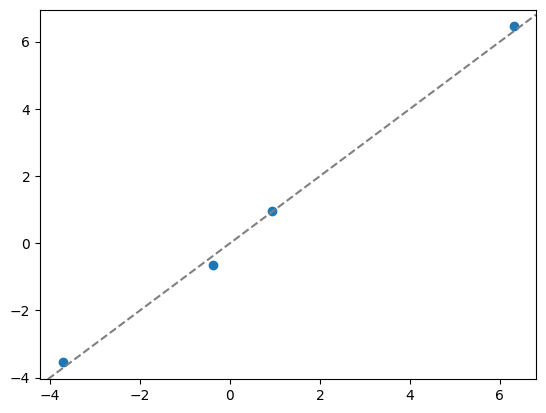

In [6]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')

In [12]:
mat = qubols.solution_vector.create_polynom_vector()

In [13]:
mat

Matrix([
[-10.3225806451613*x_001_001 + 0.32258064516129*x_001_002 + 0.645161290322581*x_001_003 + 1.29032258064516*x_001_004 + 2.58064516129032*x_001_005 + 5.16129032258065*x_001_006],
[-10.3225806451613*x_002_001 + 0.32258064516129*x_002_002 + 0.645161290322581*x_002_003 + 1.29032258064516*x_002_004 + 2.58064516129032*x_002_005 + 5.16129032258065*x_002_006],
[-10.3225806451613*x_003_001 + 0.32258064516129*x_003_002 + 0.645161290322581*x_003_003 + 1.29032258064516*x_003_004 + 2.58064516129032*x_003_005 + 5.16129032258065*x_003_006],
[-10.3225806451613*x_004_001 + 0.32258064516129*x_004_002 + 0.645161290322581*x_004_003 + 1.29032258064516*x_004_004 + 2.58064516129032*x_004_005 + 5.16129032258065*x_004_006]])

In [20]:
np.random.rand(4,4) * (mat@mat.T)

Matrix([
[0.510641056175152*(-10.3225806451613*x_001_001 + 0.32258064516129*x_001_002 + 0.645161290322581*x_001_003 + 1.29032258064516*x_001_004 + 2.58064516129032*x_001_005 + 5.16129032258065*x_001_006)*(-10.3225806451613*x_002_001 + 0.32258064516129*x_002_002 + 0.645161290322581*x_002_003 + 1.29032258064516*x_002_004 + 2.58064516129032*x_002_005 + 5.16129032258065*x_002_006) + 0.263628828660057*(-10.3225806451613*x_001_001 + 0.32258064516129*x_001_002 + 0.645161290322581*x_001_003 + 1.29032258064516*x_001_004 + 2.58064516129032*x_001_005 + 5.16129032258065*x_001_006)*(-10.3225806451613*x_003_001 + 0.32258064516129*x_003_002 + 0.645161290322581*x_003_003 + 1.29032258064516*x_003_004 + 2.58064516129032*x_003_005 + 5.16129032258065*x_003_006) + 0.310511550046297*(-10.3225806451613*x_001_001 + 0.32258064516129*x_001_002 + 0.645161290322581*x_001_003 + 1.29032258064516*x_001_004 + 2.58064516129032*x_001_005 + 5.16129032258065*x_001_006)*(-10.3225806451613*x_004_001 + 0.32258064516129*x_00

In [45]:
options = {'num_reads':20, 'iterations':3, 'num_qbits':5, 
           'encoding': RangedEfficientEncoding, 'range':10.0, 'offset':0.0,
           'sampler':dimod.ExactSolver(),}
qubols= AEQUBOLS(options)
sol_num = qubols.solve(A, b)

0 [0.0, 0.0, 0.0, 0.0] 10.0
1 [-0.5568358556771333, 6.378011777958716, -3.5394037026882863, 1.047337843009113] [6.1553951042025625, 6.155395104202553, 6.155395104202621, 6.1553951041923405]
2 [-0.44714894632536706, 6.345981429349622, -3.665937559877882, 0.9754545556627885] [3.788888888903877, 3.7888888888967944, 3.788888888900691, 3.788888888885915]


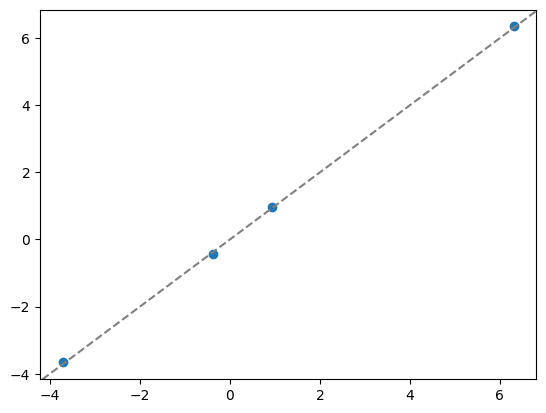

In [46]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')

In [1]:
from sympy import Symbol
vars = [Symbol('x_0'), Symbol('x_1'), Symbol('x_2')]

In [2]:
from sympy.matrices import Matrix
mat = Matrix(vars)

In [3]:
mat@mat.T

Matrix([
[ x_0**2, x_0*x_1, x_0*x_2],
[x_0*x_1,  x_1**2, x_1*x_2],
[x_0*x_2, x_1*x_2,  x_2**2]])

In [4]:
mat@mat.T@mat

Matrix([
[x_0**3 + x_0*x_1**2 + x_0*x_2**2],
[x_0**2*x_1 + x_1**3 + x_1*x_2**2],
[x_0**2*x_2 + x_1**2*x_2 + x_2**3]])

In [6]:
import numpy as np
x = np.array([[Symbol('x_0')], [Symbol('x_1')]])
A = Matrix(np.random.rand(2,2))
b = Matrix(np.random.rand(2,1))

In [7]:
p = (A @ x-b)
p = p.T @ p
p.expand()

Matrix([[0.732838409246331*x_0**2 + 1.48950293194399*x_0*x_1 - 1.51693413884578*x_0 + 0.871516585646741*x_1**2 - 1.77306389537603*x_1 + 0.901814119793327]])

In [10]:
p = x.T @ A.T @ A @ x - x.T @ A.T @ b - b.T @ A @ x + b.T @ b
p = p[0]

In [11]:
p = p.expand()
p = p.as_ordered_terms()

In [15]:
for term in p:
    print(term.args)

(0.732838409246331, x_0**2)
(1.48950293194399, x_0, x_1)
(-1.51693413884578, x_0)
(0.871516585646742, x_1**2)
(-1.77306389537603, x_1)
()


In [16]:
import dimod

In [17]:
poly = {(0,): -1, (1,): 1, (2,): 1.5, (0, 1): -1, (0, 1, 2): -2}
bqm = dimod.make_quadratic(poly, 5.0, dimod.SPIN)

In [18]:
poly

{(0,): -1, (1,): 1, (2,): 1.5, (0, 1): -1, (0, 1, 2): -2}

In [19]:
bqm

BinaryQuadraticModel({0: -3.5, 1: -1.5, '0*1': -2.5, 'aux0,1': -5.0, 2: 1.5}, {(1, 0): 1.5, ('0*1', 0): 2.5, ('0*1', 1): 2.5, ('aux0,1', 0): 5.0, ('aux0,1', 1): 5.0, ('aux0,1', '0*1'): 5.0, (2, '0*1'): -2.0}, 10.0, 'SPIN')

In [20]:
'x_0**2'.split('**')

['x_0', '2']

In [21]:
int('2')

2

In [22]:
('x',)*2

('x', 'x')

In [24]:
tuple(str(m) for m in ['x','y'])

('x', 'y')